# Balls and Strikes Effects

## 6.2 Hitter’s Counts and Pitcher’s Counts

### 6.2.1 An example for a single pitcher

Analyzing Mike Mussina's career performance splits by count. The tOPS+ metric compares a player's OPS in each count situation to their overall OPS (100 = average, >100 = better than average, <100 = worse than average).

In [1]:
import pandas as pd
import numpy as np

balls = np.repeat([0, 1, 2, 3], 3)
strikes = np.tile([0, 1, 2], 4)

mussina = pd.DataFrame({
    'balls': balls,
    'strikes': strikes,
    'value': [
        100, 72, 30, 118, 82, 38,
        157, 114, 64, 207, 171, 122
    ]
})
mussina

,balls,strikes,value
0,0,0,100
1,0,1,72
2,0,2,30
3,1,0,118
4,1,1,82
5,1,2,38
6,2,0,157
7,2,1,114
8,2,2,64
9,3,0,207


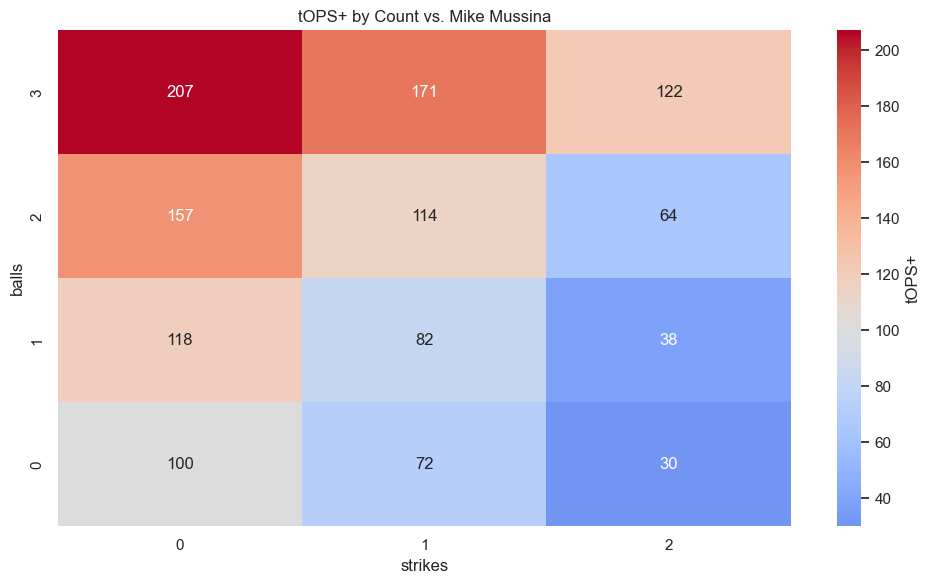

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style='darkgrid', palette='deep')

fig, ax = plt.subplots(figsize=(10, 6))

pivot_data = mussina.pivot(index='balls', columns='strikes', values='value')

sns.heatmap(
    pivot_data,
    annot=True,
    fmt='g',
    cmap='coolwarm',
    center=100,
    cbar_kws={'label': 'tOPS+'},
    ax=ax
)

ax.invert_yaxis()

ax.set_xlabel('strikes')
ax.set_ylabel('balls')
ax.set_title('tOPS+ by Count vs. Mike Mussina')

plt.tight_layout()
plt.show()


**Count Categories:**
- **Pitcher's counts** (0-2, 1-2, 0-1): Batters perform poorly (tOPS+ well below 100)
- **Hitter's counts** (3-0, 3-1, 2-0): Batters dominate (tOPS+ significantly above 100)
- **Neutral counts** (0-0, 1-1): Performance near average

The heatmap shows batters facing Mussina performed over 2x better in 3-0 counts (207) compared to 0-2 counts (30).

### 6.2.2 Pitch sequences from Retrosheet

Retrosheet encodes each pitch in a plate appearance as a character string. For example "FBSX" means:
- F = Foul ball
- B = Ball
- S = Called strike
- X = Ball in play

Need to clean and analyze sequences to determine which plate appearances passed through specific counts.

In [3]:
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

retro2016[['pitch_seq_tx']].head(10)

,pitch_seq_tx
0,BX
1,X
2,SFS
3,BCX
4,BSS*B1S
5,BBX
6,BCX
7,CX
8,BCCS
9,SBFX


#### String manipulation for pitch sequences

To analyze counts:
1. Remove non-pitch characters (ex: pickoff attempts, pitchouts, etc)
2. Count balls (B) and strikes (S, C, F, etc) to determine the count
3. Identify which plate appearances passed through specific counts

In [4]:
sequences = retro2016['pitch_seq_tx'].fillna('')

cleaned = sequences.str.replace(r'[.>123N+*]', '', regex=True)

example_df = pd.DataFrame({
    'original': sequences.head(10),
    'cleaned': cleaned.head(10),
    'length': cleaned.head(10).str.len()
})
example_df

,original,cleaned,length
0,BX,BX,2
1,X,X,1
2,SFS,SFS,3
3,BCX,BCX,3
4,BSS*B1S,BSSBS,5
5,BBX,BBX,3
6,BCX,BCX,3
7,CX,CX,2
8,BCCS,BCCS,4
9,SBFX,SBFX,4


#### 6.2.2.1 Functions for string manipulation

In [5]:
len("BBSBFFFX")

8

Using `str.contains()` and `np.where()` functions to search for patterns

In [6]:
sequences = pd.Series(["BBX", "C11BBC1S", "1X"])
sequences

0         BBX
1    C11BBC1S
2          1X
dtype: object

Finding and replacing indices with patterns

In [7]:
# Slightly different compared to R Book output as Python is 0 based index and R is 1 based
np.where(sequences.str.contains("1"))[0]

array([1, 2])

In [8]:
sequences.str.contains("1")

0    False
1     True
2     True
dtype: bool

In [9]:
sequences.str.contains("11")

0    False
1     True
2    False
dtype: bool

In [10]:
sequences.str.replace("1", "", regex=False)

0      BBX
1    CBBCS
2        X
dtype: object

#### 6.2.2.2 Finding plate appearances going through a given count

In [11]:
fields = pd.read_csv('../data/fields.csv')
headers = fields['Header'].str.lower().tolist()

retro2016 = pd.read_csv('../data/all2016.csv', names=headers, low_memory=False)

In [12]:
pbp2016 = retro2016.copy()
pbp2016['pseq'] = pbp2016['pitch_seq_tx'].str.replace(r'[.>123N+*]', '', regex=True)

In [13]:
# Detect 1-0 counts
pbp2016['c10'] = pbp2016['pseq'].str.match(r'^[BIPV]')

In [14]:
# Detect 0-1 counts
pbp2016['c01'] = pbp2016['pseq'].str.match(r'^[CFKLMOQRST]')

In [15]:
pbp2016[['pitch_seq_tx', 'c10', 'c01']].head(10)

,pitch_seq_tx,c10,c01
0,BX,True,False
1,X,False,False
2,SFS,False,True
3,BCX,True,False
4,BSS*B1S,True,False
5,BBX,True,False
6,BCX,True,False
7,CX,False,True
8,BCCS,True,False
9,SBFX,False,True


### 6.2.3 Expected run value by count

In [16]:
import sys
sys.path.append('../')
from src.retrosheet_utils import retrosheet_add_states, retrosheet_add_counts

In [17]:
pbp2016 = retrosheet_add_states(pbp2016)

In [18]:
# Load the 2016 run expectancy matrix created in Ch 5
erm_2016 = pd.read_pickle('../data/erm_2016.pkl')

pbp2016 = (pbp2016
    .merge(erm_2016[['bases', 'outs_ct', 'mean_run_value']], 
           on=['bases', 'outs_ct'], how='left')
    .rename(columns={'mean_run_value': 'rv_start'})
    .merge(erm_2016.rename(columns={'bases': 'new_bases', 'outs_ct': 'new_outs'})[
        ['new_bases', 'new_outs', 'mean_run_value']], 
           on=['new_bases', 'new_outs'], how='left')
    .rename(columns={'mean_run_value': 'rv_end'})
    .fillna({'rv_end': 0}) 
)

pbp2016['run_value'] = pbp2016['rv_end'] - pbp2016['rv_start'] + pbp2016['runs_scored']


In [19]:
pbp2016 = retrosheet_add_counts(pbp2016)

In [20]:
pbp2016[[
    'game_id', 'event_id', 'run_value', 'c00', 'c10', 'c20', 
    'c11', 'c01', 'c30', 'c21', 'c31', 'c02', 'c12', 'c22', 'c32'
]].head(5)

,game_id,event_id,run_value,c00,c10,c20,c11,c01,c30,c21,c31,c02,c12,c22,c32
0,ANA201604040,1,0.635008,True,True,False,False,False,False,False,False,False,False,False,False
1,ANA201604040,2,-0.196288,True,False,False,False,False,False,False,False,False,False,False,False
2,ANA201604040,3,-0.564935,True,False,False,False,True,False,False,False,True,False,False,False
3,ANA201604040,4,0.848252,True,True,False,True,False,False,False,False,False,False,False,False
4,ANA201604040,5,-0.220206,True,True,False,True,False,False,False,False,False,True,True,False


In [21]:
(pbp2016[pbp2016['c10'] | pbp2016['c01']]
    .groupby(['c10', 'c01'])
    .agg(
        num_ab=('c10', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,c10,c01,num_ab,mean_run_value
0,False,True,94108,-0.039441
1,True,False,76165,0.037064


In [22]:
pbp_counts = pbp2016[[col for col in pbp2016.columns if col.startswith('c')] + ['run_value']]

In [23]:
pbp_counts_tidy = pbp_counts.melt(
    id_vars=['run_value'],
    var_name='count',
    value_name='passed_thru'
)

pbp_counts_tidy.sample(6)

,run_value,count,passed_thru
2249921,0.244231,c32,True
765329,-0.230266,c30,False
1090716,0.359812,c02,False
811138,0.359812,c30,False
886017,-0.291928,c30,False
1947010,-0.291928,c22,False


In [24]:
run_value_by_count = (pbp_counts_tidy[pbp_counts_tidy['passed_thru'] == True]
    .groupby('count')
    .agg(
        num_ab=('count', 'size'),
        value=('run_value', 'mean')
    )
    .reset_index()
)

In [25]:
run_value_by_count

,count,num_ab,value
0,c00,190715,0.001228
1,c01,94108,-0.039441
2,c02,38358,-0.094270
3,c10,76165,0.037064
4,c11,75227,-0.014829
5,c12,54205,-0.071311
6,c20,26298,0.091729
7,c21,38847,0.028210
8,c22,44254,-0.036794
9,c30,8594,0.189298


In [26]:
run_value_by_count['balls'] = run_value_by_count['count'].str[1]
run_value_by_count['strikes'] = run_value_by_count['count'].str[2]

run_value_by_count['balls'] = run_value_by_count['balls'].astype(int)
run_value_by_count['strikes'] = run_value_by_count['strikes'].astype(int)

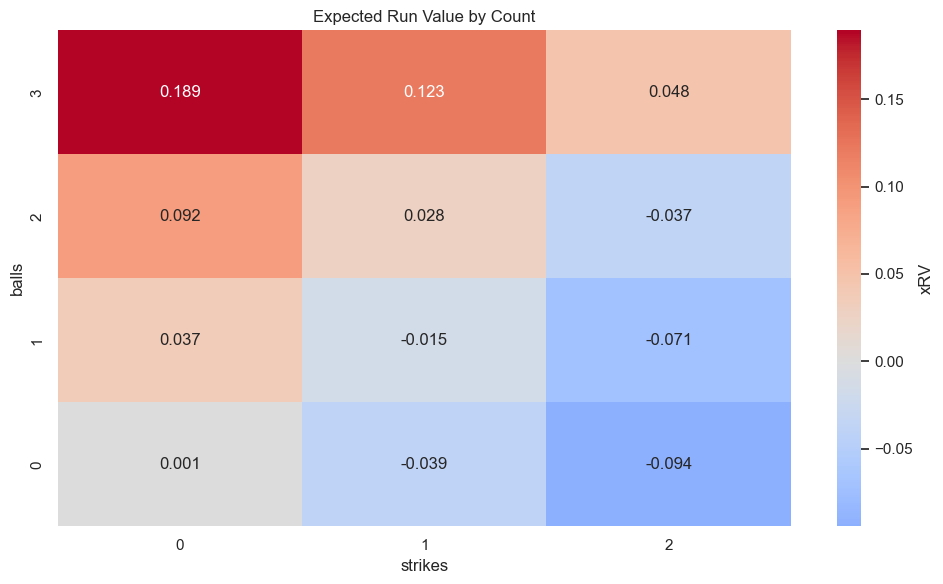

In [27]:
import matplotlib.pyplot as plt
import seaborn as sns

pivot_data = run_value_by_count.pivot(index='balls', columns='strikes', values='value')

fig, ax = plt.subplots(figsize=(10, 6))

sns.heatmap(
    pivot_data,
    annot=True,
    fmt='.3f',
    cmap='coolwarm',
    center=0,
    cbar_kws={'label': 'xRV'},
    ax=ax
)

ax.invert_yaxis()

ax.set_xlabel('strikes')
ax.set_ylabel('balls')
ax.set_title('Expected Run Value by Count')

plt.tight_layout()
plt.show()


### 6.2.4 The importance of the previous count

In [28]:
count22 = pbp2016[pbp2016['c22'] == True]

count22.agg(
    num_ab=('run_value', 'size'),
    mean_run_value=('run_value', 'mean')
).transpose()

,num_ab,mean_run_value
run_value,44254.0,-0.036794


In [29]:
count22 = count22.copy()
count22['after2'] = 'other'
count22.loc[count22['c20'] == True, 'after2'] = '2-0'
count22.loc[count22['c02'] == True, 'after2'] = '0-2'
count22.loc[count22['c11'] == True, 'after2'] = '1-1'

(count22.groupby('after2')
    .agg(
        num_ab=('after2', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,after2,num_ab,mean_run_value
0,0-2,9837,-0.031081
1,1-1,28438,-0.037636
2,2-0,5979,-0.042190


In [30]:
count11 = pbp2016[pbp2016['c11'] == True].copy()

count11['after2'] = count11['c10'].apply(lambda x: '1-0' if x else '0-1')

(count11.groupby('after2')
    .agg(
        num_ab=('after2', 'size'),
        mean_run_value=('run_value', 'mean')
    )
    .reset_index()
)

,after2,num_ab,mean_run_value
0,0-1,38760,-0.012231
1,1-0,36467,-0.017591


## 6.3 Behaviors by Count

In [31]:
# Using read_r function to load RData file to Python

import pyreadr

balls_strikes_count = pyreadr.read_r('../data/balls_strikes_count.RData')

print(balls_strikes_count.keys())

odict_keys(['cabrera', 'verlander', 'sanchez', 'umpires'])


### 6.3.1 Swinging tendencies by count

In [32]:
# Miguel Cabrera
cabrera = balls_strikes_count['cabrera']
cabrera.columns

Index(['season', 'gamedate', 'pitch_type', 'balls', 'strikes', 'speed', 'px',
       'pz', 'swung', 'hitx', 'hity', 'hit_outcome'],
      dtype='object')

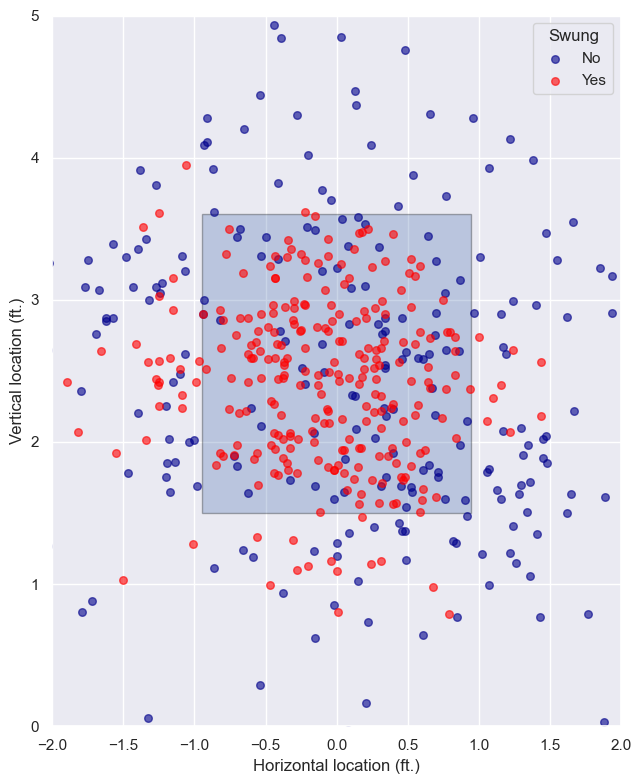

In [33]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches

cabrera_sample = cabrera.sample(500)

fig, ax = plt.subplots(figsize=(8, 8))

strike_zone = patches.Rectangle(
    (-0.947, 1.5), 
    width=0.947 * 2,
    height=3.6 - 1.5,
    edgecolor='black',
    alpha=0.3
)
ax.add_patch(strike_zone)

colors = {0: 'darkblue', 1: 'red'}
for swung_val, color in colors.items():
    subset = cabrera_sample[cabrera_sample['swung'] == swung_val]
    ax.scatter(subset['px'], subset['pz'], 
               c=color, label='Yes' if swung_val == 1 else 'No',
               alpha=0.6, s=30)

ax.set_aspect('equal')

ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')


ax.legend(title='Swung', loc='upper right')

plt.tight_layout()
plt.show()


**Note:** Using LogisticGAM (`pygam` library) as Python alternative to R's `loess()` for smoothing swing probabilities.  Output differs slightly compared to R examples.

References on pygam library:
 - https://www.geeksforgeeks.org/artificial-intelligence/generalized-additive-model-in-python/
 - https://pygam.readthedocs.io/en/latest/

In [85]:
from pygam import LogisticGAM, s

miggy_gam = LogisticGAM(
    s(0, n_splines=10) + s(1, n_splines=10),
    lam=0.6
).fit(cabrera[['px', 'pz']], cabrera['swung'])

In [86]:
px_range = np.arange(-2, 2.1, 0.1)
pz_range = np.arange(0, 6.1, 0.1)

pred_area = pd.DataFrame({
    'px': np.repeat(px_range, len(pz_range)),
    'pz': np.tile(pz_range, len(px_range))
})

pred_area_fit = pred_area.copy()
pred_area_fit['fit'] = miggy_gam.predict_proba(pred_area[['px', 'pz']])

In [93]:
down_broadway = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 0) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 2.5) < 0.01)
][['px', 'pz', 'fit']]

down_broadway['px'] = down_broadway['px'].round(1)
down_broadway['pz'] = down_broadway['pz'].round(1)

down_broadway

,px,pz,fit
1245,0.0,2.5,0.841105


In [94]:
ball_in_dirt = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 0) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 0) < 0.01)
][['px', 'pz', 'fit']]

ball_in_dirt['px'] = ball_in_dirt['px'].round(1)
ball_in_dirt['pz'] = ball_in_dirt['pz'].round(1)

ball_in_dirt

,px,pz,fit
1220,0.0,0.0,0.098336


In [95]:
way_outside = pred_area_fit[
    (np.abs(pred_area_fit['px'] - 2) < 0.01) & 
    (np.abs(pred_area_fit['pz'] - 2.5) < 0.01)
][['px', 'pz', 'fit']]

way_outside['px'] = way_outside['px'].round(1)
way_outside['pz'] = way_outside['pz'].round(1)

way_outside

,px,pz,fit
2465,2.0,2.5,0.039772


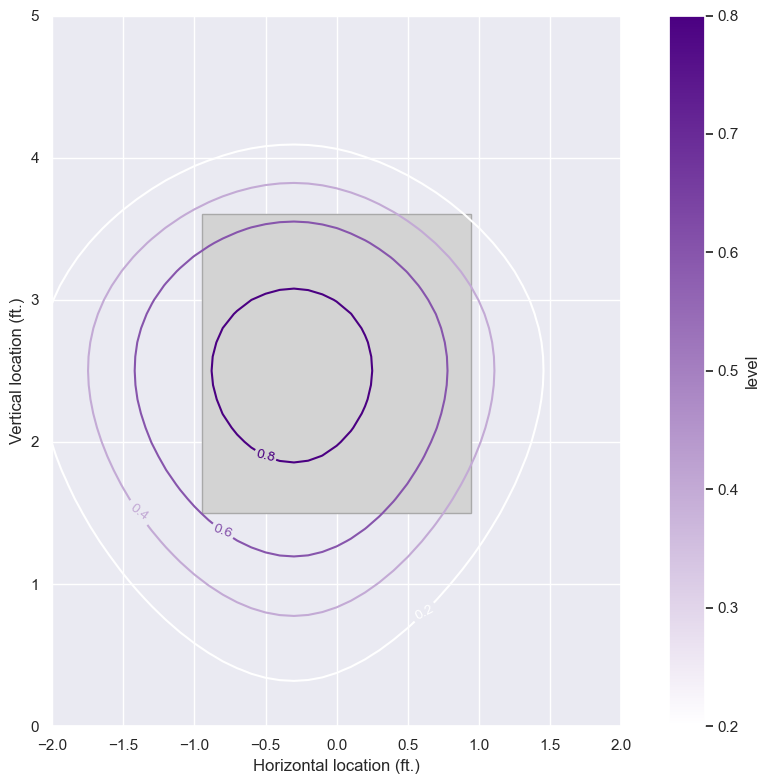

In [99]:
from matplotlib.patches import Rectangle
from matplotlib.colors import LinearSegmentedColormap

Z = pred_area_fit.pivot(index='pz', columns='px', values='fit').values
X, Y = np.meshgrid(px_range, pz_range)

fig, ax = plt.subplots(figsize=(10, 8))

strike_zone = Rectangle(
    (-0.947, 1.5), 
    width=0.947 * 2,
    height=3.6 - 1.5,
    facecolor='lightgray', 
    edgecolor='darkgray',
    linewidth=1
)
ax.add_patch(strike_zone)

cmap = LinearSegmentedColormap.from_list('white_to_blue', ['white', '#4B0082'])
contours = ax.contour(X, Y, Z, levels=[0.2, 0.4, 0.6, 0.8], cmap=cmap, linewidths=1.5)
ax.clabel(contours, inline=True, fontsize=10, fmt='%.1f')

sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=0.2, vmax=0.8))
plt.colorbar(sm, ax=ax, label='level')

ax.set_xlabel('Horizontal location (ft.)')
ax.set_ylabel('Vertical location (ft.)')
ax.set_xlim(-2, 2)
ax.set_ylim(0, 5)
ax.set_aspect('equal')

plt.tight_layout()
plt.show()